# mlrose_ky Generator and Runner Usage Examples - Andrew Rollings
*Modified by Kyle Nakamura*

## Overview

These examples will not solve assignment 2 for you, but they will give you some idea on how to use the problem generator and runner classes.

Hopefully this will result in slightly fewer "How do I \<insert basic usage here\>" questions every semester...

Also, and in case it hasn't been made clear enough by the TAs, using any of the visualizations from this tutorial for your report is a bad idea for two reasons: 
1. It provides nothing useful as far as the assignment goes, and 
2. The TAs will undoubtedly frown upon it.

Visualization is part of the analysis and, for the most part, you're supposed to do that by yourself. Just including
images of the before/after state of a problem really isn't useful in terms of what you're supposed to be analyzing.

## Import Libraries

In [1]:
%pip install chess IPython

Note: you may need to restart the kernel to use updated packages.


In [2]:
from IPython.display import HTML

import numpy as np
import logging
import networkx as nx
import matplotlib.pyplot as plt
import string

from ast import literal_eval
import chess

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score

import mlrose_ky as mlrose
from mlrose_ky.generators import QueensGenerator, MaxKColorGenerator, TSPGenerator
from mlrose_ky.runners import SARunner, GARunner, NNGSRunner

# Hide warnings from libraries
logging.basicConfig(level=logging.WARNING)

## Example 1: Solving the 8-Queens problem using the SA algorithm

### Initializing and viewing the problem

First, we'll use the `QueensGenerator` to create an instance of the 8-Queens problem.

In [3]:
# Generate a new 8-Queens optimization problem using a fixed seed
problem = QueensGenerator.generate(seed=123456, size=8)

The initial, un-optimized state can be seen below, both as a list and as a chess board.

Initial state: [2 3 3 2 7 0 1 1]


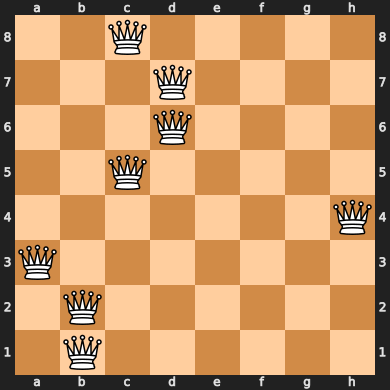

In [4]:
# View the initial state as a list
state = problem.get_state()
print('Initial state:', state)

# View the initial state as a chess board
board_layout = "/".join(["".join(([str(s)] if s > 0 else []) + ["Q"] + ([str((7 - s))] if s < 7 else [])) for s in state])
chess.Board(board_layout)  # You may need to "trust" this notebook for the board visualization to work

### Solving 8-Queens using a Runner (i.e., grid search)

Runners are used to execute "grid search" experiments on optimization problems.

We'll use the Simulated Annealing Runner (SARunner) to perform a grid search on the 8-Queens problem and then extract the optimal SA hyperparameters.

Here is a brief explanation of the SARunner parameters used in the example below:
- `max_attempts`: A list of maximum attempts to try improving the fitness score before terminating a run
- `temperature_list`: A list of temperatures to try when initializing the SA algorithm's decay function (e.g., `GeomDecay(init_temp=1.0)`)
- `decay_list`: A list of decay schedules to try as the SA algorithm's decay function (e.g., `GeomDecay`, `ExpDecay`, etc.)
- `iteration_list`: A list of iterations to snapshot the state of the algorithm at (only determines the rows that the Runner will output)

*Disclaimer: the values used here are just toy values picked specifically for this example. 
You will have to choose your own range of values for your experiments. 
I strongly recommend you don't just copy these, or you will find that the grading is unlikely to go the way you would like.* 

In [5]:
# Create an SA Runner instance to solve the problem
sa = SARunner(
    problem=problem,
    experiment_name="queens_8_sa",
    seed=123456,
    output_directory=None,  # Note: specify an output directory (str) to have these results saved to disk
    max_attempts=100,
    temperature_list=[0.1, 0.5, 0.75, 1.0, 2.0, 5.0],
    decay_list=[mlrose.GeomDecay],
    iteration_list=2 ** np.arange(11),  # list of 11 integers from 2^0 to 2^11
)

# Run the SA Runner and retrieve its results
df_run_stats, df_run_curves = sa.run()

In [6]:
# Calculate some simple stats about the experiment
temperatures_per_run = max(1, len(sa.temperature_list))
decays_per_run = max(1, len(sa.decay_list))
iters_per_run = len(sa.iteration_list) + 1
total_runs = temperatures_per_run * decays_per_run

print(f"The experiment executed {total_runs} runs, each with {iters_per_run} snapshots at different iterations.")
print(f"In total, the output dataframe should contain {total_runs * iters_per_run} rows.")

The experiment executed 6 runs, each with 12 snapshots at different iterations.
In total, the output dataframe should contain 72 rows.


The `df_run_stats` dataframe contains snapshots of the state of the algorithm at the iterations specified in the `iteration_list`.

Since `iterations_list` contains 11 numbers, and iteration 0 is always included in the results, each run will take up 12 rows of the dataframe.

The first 12 rows (i.e., results from the first run) are shown below:

In [7]:
HTML(df_run_stats[["Iteration", "Fitness", "FEvals", "Time", "State"]][:iters_per_run].to_html(index=False))

Some information was intentionally excluded from the previous output. Let's now preview the entirety of the first run:

In [8]:
HTML(df_run_stats[:iters_per_run].to_html(index=False))

**What does all this information tell us about the first run of our experiment?**

1. `Iteration` shows the index of the snapshot, with 12 snapshots per run in this example.
2. `Fitness` shows the fitness score of the state at the corresponding iteration, where 0.0 is optimal for minimization problems.
3. `FEvals` shows the number of fitness function evaluations performed by the algorithm at the corresponding iteration.
4. `Time` shows the time elapsed (calculated using `time.perf_counter()`) up to the corresponding iteration.
5. `State` shows the state of the algorithm at the corresponding iteration (see `mlrose_ky.fitness.queens` for more details).
6. `Temperature` shows the decay function (and its parameters) that was used for this run. We will have 6 unique values in this column, one for each run.
7. `max_iters` shows the maximum number of iterations allowed for the algorithm to run. It defaults to `max(iteration_list)` for all Runners, which is 1024 in this case.

To pick out the most performant run from the dataframe, we need to find the row with the best fitness.
Since Queens is a minimization problem, we're looking for the row with minimal fitness (i.e., zero).

It's likely that multiple runs will achieve the same fitness, so we need to find the run that achieved the best `Fitness` in the fewest `FEvals` (*Note: we could make this selection using `Iterations` or `Time` if we so desired.*)

In [9]:
best_fitness = df_run_stats["Fitness"].min()  # Should be 0.0 in this case

# Get all runs with the best fitness value
best_runs = df_run_stats[df_run_stats["Fitness"] == best_fitness]
best_runs

Iteration  Fitness  FEvals      Time                     State  \
10        512      0.0     461  0.043205  [1, 5, 0, 6, 3, 7, 2, 4]   
11       1024      0.0     461  0.043205  [1, 5, 0, 6, 3, 7, 2, 4]   
22        512      0.0     461  0.046990  [1, 5, 0, 6, 3, 7, 2, 4]   
23       1024      0.0     461  0.046990  [1, 5, 0, 6, 3, 7, 2, 4]   
58        512      0.0     427  0.045990  [7, 1, 3, 0, 6, 4, 2, 5]   
59       1024      0.0     427  0.045990  [7, 1, 3, 0, 6, 4, 2, 5]   
70        512      0.0     583  0.061415  [6, 0, 2, 7, 5, 3, 1, 4]   
71       1024      0.0     583  0.061415  [6, 0, 2, 7, 5, 3, 1, 4]   

   schedule_type  schedule_init_temp  schedule_decay  schedule_min_temp  \
10     geometric                 0.1            0.99              0.001   
11     geometric                 0.1            0.99              0.001   
22     geometric                 0.5            0.99              0.001   
23     geometric                 0.5            0.99              0.001   
58     geometric                 2.0            0.99              0.001   
59     geometric                 2.0            0.99              0.001   
70     geometric                 5.0            0.99              0.001   
71     geometric                 5.0            0.99              0.001   

    schedule_current_value Temperature  max_iters  
10                0.099957         0.1       1024  
11                0.099957         0.1       1024  
22                0.499764         0.5       1024  
23                0.499764         0.5       1024  
58                1.999076         2.0       1024  
59                1.999076         2.0       1024  
70                4.996915         5.0       1024  
71                4.996915         5.0       1024

This gives us our candidates for the best run. 

The best run will be the one that achieved the best fitness in the fewest evaluations.

In [10]:
minimum_evaluations = best_runs["FEvals"].min()  # Should be 461 in this case

# Extract the best run with the minimum number of evaluations
best_run = best_runs[best_runs["FEvals"] == minimum_evaluations]

The best run using these criteria is as follows:

In [11]:
print(best_run.iloc[0])

Iteration                                      512
Fitness                                        0.0
FEvals                                         427
Time                                       0.04599
State                     [7, 1, 3, 0, 6, 4, 2, 5]
schedule_type                            geometric
schedule_init_temp                             2.0
schedule_decay                                0.99
schedule_min_temp                            0.001
schedule_current_value                    1.999076
Temperature                                    2.0
max_iters                                     1024
Name: 58, dtype: object


Which has the following identifying state information:

In [12]:
best_temperature_param = best_run["Temperature"].iloc[0].init_temp
best_temperature_param

2.0

To map this result back to the original output of the Runner, we are looking for all rows in `df_run_stats` where the temperature is equal to 2.

In [13]:
run_stats_best_run = df_run_stats[df_run_stats["schedule_init_temp"] == best_temperature_param]
run_stats_best_run[["Iteration", "Fitness", "FEvals", "Time", "State"]]

Iteration  Fitness  FEvals      Time                     State
48          0     11.0       0  0.000129  [1, 2, 2, 1, 0, 3, 7, 3]
49          1      9.0       2  0.001748  [1, 2, 2, 0, 0, 3, 7, 3]
50          2      8.0       4  0.003499  [1, 2, 2, 0, 0, 3, 7, 5]
51          4      8.0       7  0.005148  [1, 2, 2, 5, 0, 3, 7, 5]
52          8      7.0      14  0.006856  [1, 2, 2, 5, 0, 3, 5, 5]
53         16      6.0      27  0.008827  [3, 2, 3, 5, 0, 1, 5, 5]
54         32      4.0      57  0.011565  [3, 5, 6, 5, 5, 0, 4, 7]
55         64      5.0     114  0.016527  [2, 0, 3, 6, 1, 2, 1, 7]
56        128      3.0     205  0.023965  [2, 0, 6, 3, 5, 0, 4, 3]
57        256      2.0     358  0.037346  [7, 1, 3, 6, 6, 4, 0, 5]
58        512      0.0     427  0.045990  [7, 1, 3, 0, 6, 4, 2, 5]
59       1024      0.0     427  0.045990  [7, 1, 3, 0, 6, 4, 2, 5]

And the best state associated with this is:

In [14]:
best_state = run_stats_best_run[["schedule_current_value", "schedule_init_temp", "schedule_min_temp"]].tail(1)
best_state

schedule_current_value  schedule_init_temp  schedule_min_temp
59                1.999076                 2.0              0.001

The final state is as follows:

[7, 1, 3, 0, 6, 4, 2, 5]


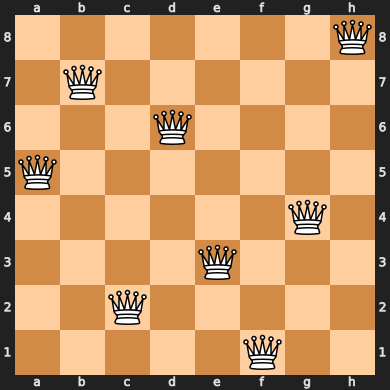

In [15]:
state = literal_eval(run_stats_best_run["State"].tail(1).values[0])
print(state)

board_layout = "/".join(["".join(([str(s)] if s > 0 else []) + ["Q"] + ([str((7 - s))] if s < 7 else [])) for s in state])
board = chess.Board(board_layout)
board

### Example 2: Generating and Running Max K Color using the GA algorithm

In [16]:
# Generate a new Max K problem using a fixed seed.
problem = MaxKColorGenerator().generate(seed=123456, number_of_nodes=10, max_connections_per_node=3, max_colors=3)

The input graph generated for the problem looks like this:

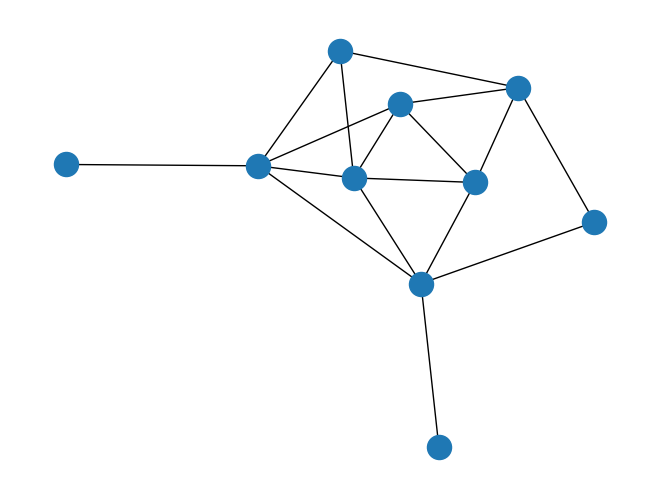

In [17]:
nx.draw(problem.source_graph, pos=nx.spring_layout(problem.source_graph, seed=3))
plt.show()

In [18]:
# create a runner class and solve the problem
ga = GARunner(
    problem=problem,
    experiment_name="max_k_ga",
    output_directory=None,  # note: specify an output directory to have results saved to disk
    seed=123456,
    iteration_list=2 ** np.arange(11),
    population_sizes=[10, 20, 50],
    mutation_rates=[0.1, 0.2, 0.5],
)

# the two data frames will contain the results
df_run_stats, df_run_curves = ga.run()

The preceding code will run the `GA` algorithm nine times for at most 1024 iterations per run.
Each run is a permutation from the list of `population_sizes` and `mutation_rates`.

Note that the initial state parameters here are just toy values picked specifically
for this example. You will have to choose your own range of values for your
assignment. I strongly recommend you don't just copy these, or you will find
that the grading is unlikely to go the way you would like.

Really. I mean it... A mutation rate of 0.5 is little better than a pure random search.

The output in the `df_run_stats` dataframe contains snapshots of the state of the algorithm at the iterations
specified in the `iteration_list` passed into the runner class.

The first row (corresponding to the first run of this algorithm) are as follows:

In [19]:
df_run_stats[["Iteration", "Fitness", "FEvals", "Time", "State"]][0:1]

Iteration  Fitness  FEvals      Time                           State
0          0      3.0      10  0.000374  [1, 2, 2, 1, 0, 0, 0, 0, 2, 2]

The state information is excluded from the previous output.

A sample of this is below:

In [20]:
state_sample = df_run_stats[["Population Size", "Mutation Rate"]][:1]
state_sample

Population Size  Mutation Rate
0               10            0.1

So, to pick out the most performant run from the dataframe, you need to find the row with the best fitness.
As Max-K-Color is a minimization problem, you'd pick the row with the minimum fitness.

However, I'm going to look in the `run_curves` (which stores minimal basic information every iteration) to
find out which input state achieved the best fitness in the fewest fitness evaluations.

In [21]:
best_fitness = df_run_curves["Fitness"].min()
best_runs = df_run_curves[df_run_curves["Fitness"] == best_fitness]
best_runs

Iteration      Time  Fitness  FEvals  Population Size  Mutation Rate  \
3           4  0.007954      0.0    57.0               10            0.1   
7           4  0.007954      0.0    57.0               10            0.2   
15          8  0.003314      0.0   101.0               10            0.5   
20          5  0.000228      0.0   127.0               20            0.1   
22          2  0.005333      0.0    64.0               20            0.2   
25          3  0.007171      0.0    85.0               20            0.5   
34          9  0.003736      0.0   511.0               50            0.1   
37          3  0.007171      0.0   205.0               50            0.2   
41          4  0.007954      0.0   256.0               50            0.5   

    max_iters  
3        1024  
7        1024  
15       1024  
20       1024  
22       1024  
25       1024  
34       1024  
37       1024  
41       1024

This gives us nine candidates for the best run. We are going to pick the one with
that reached the best fitness value in the fewest number of evaluations.

(We could also have chosen to use `Iterations` as our criteria.)

In [22]:
minimum_evaluations = best_runs["FEvals"].min()

best_run = best_runs[best_runs["FEvals"] == minimum_evaluations]

The best runs using these criteria is as follows:

In [23]:
best_run

Iteration      Time  Fitness  FEvals  Population Size  Mutation Rate  \
3          4  0.007954      0.0    57.0               10            0.1   
7          4  0.007954      0.0    57.0               10            0.2   

   max_iters  
3       1024  
7       1024

We will arbitrarily pick the first row for this example,
which has the following identifying state information:

In [24]:
best_mr = best_run["Mutation Rate"].iloc()[0]
best_pop_size = best_run["Population Size"].iloc()[0]
print(f"Best Mutation Rate: {best_mr}, best Population Size: {best_pop_size}")

Best Mutation Rate: 0.1, best Population Size: 10


To map this back to the `run_stats` we look at the configuration data included in
the curve data. The curve data includes at least the minimum identifying information
to determine which run each row came from.

In this case, the values we are looking for are the `Mutation Rate` and `Population Size`.

So, we are looking for all rows in `df_run_stats` where the mutation rate and population size are equal to our best values.

In [25]:
run_stats_best_run = df_run_stats[(df_run_stats["Mutation Rate"] == best_mr) & (df_run_stats["Population Size"] == best_pop_size)]
run_stats_best_run[["Iteration", "Fitness", "FEvals", "Time"]]

Iteration  Fitness  FEvals      Time
0           0      3.0      10  0.000374
1           1      3.0      21  0.002873
2           2      2.0      33  0.005333
3           4      0.0      57  0.007954
4           8      0.0      57  0.007954
5          16      0.0      57  0.007954
6          32      0.0      57  0.007954
7          64      0.0      57  0.007954
8         128      0.0      57  0.007954
9         256      0.0      57  0.007954
10        512      0.0      57  0.007954
11       1024      0.0      57  0.007954

And the best state associated with this is:

In [26]:
best_state = run_stats_best_run[["State"]].tail(1)
best_state

State
11  [0, 1, 2, 0, 0, 2, 0, 1, 2, 1]

For the following node ordering:

In [27]:
print([n for n in problem.source_graph.nodes])

[0, 2, 8, 1, 3, 4, 6, 7, 9, 5]


Reordering the state by ascending node number gives the following:

In [28]:
color_indexes = literal_eval(run_stats_best_run["State"].tail(1).values[0])
ordered_state = [color_indexes[n] for n in problem.source_graph.nodes]
print(ordered_state)

[0, 2, 2, 1, 0, 0, 0, 1, 1, 2]


Which results in a graph looking like this:

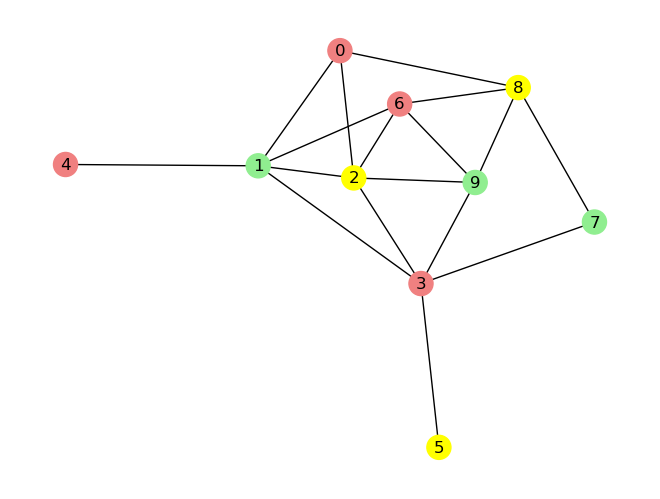

In [29]:
colors = ["lightcoral", "lightgreen", "yellow"]
node_color_map = [colors[s] for s in ordered_state]

nx.draw(problem.source_graph, pos=nx.spring_layout(problem.source_graph, seed=3), with_labels=True, node_color=node_color_map)
plt.show()

### Example 3: Generating and Running TSP using the GA algorithm

In [30]:
# Generate a new TSP problem using a fixed seed.
problem = TSPGenerator().generate(seed=123456, number_of_cities=20)

The input graph generated for the problem looks like this:

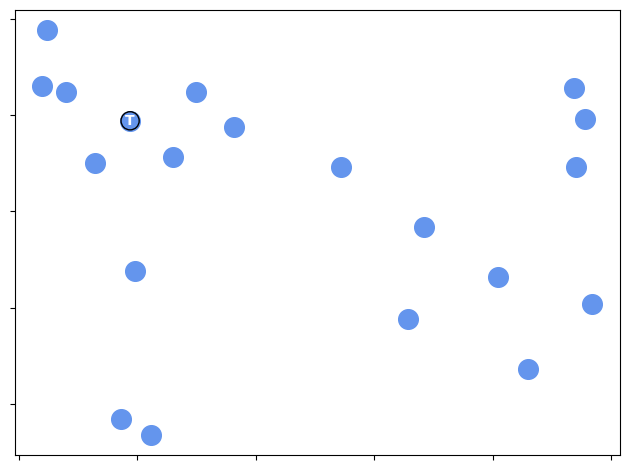

In [31]:
fig, ax = plt.subplots(1)  # Prepare 2 plots
ax.set_yticklabels([])
ax.set_xticklabels([])
for i, (x, y) in enumerate(problem.coords):
    ax.scatter(x, y, s=200, c="cornflowerblue")  # plot A
node_labels = {k: str(v) for k, v in enumerate(string.ascii_uppercase) if k < len(problem.source_graph.nodes)}
for i in node_labels.keys():
    x, y = problem.coords[i]
plt.text(
    x,
    y,
    node_labels[i],
    ha="center",
    va="center",
    c="white",
    fontweight="bold",
    bbox=dict(boxstyle=f"circle,pad=0.15", fc="cornflowerblue"),
)

plt.tight_layout()
plt.show()

In [32]:
# create a runner class and solve the problem
ga = GARunner(
    problem=problem,
    experiment_name="tsp_ga",
    output_directory=None,  # note: specify an output directory to have results saved to disk
    seed=123456,
    iteration_list=2 ** np.arange(11),
    population_sizes=[10, 20],
    mutation_rates=[0.1, 0.25, 0.5],
)

# the two data frames will contain the results
df_run_stats, df_run_curves = ga.run()

The preceding code will run the `GA` algorithm nine times for at most 1024 iterations per run.
Each run is a permutation from the list of `population_sizes` and `mutation_rates`.

Note that the initial state parameters here are just toy values picked specifically
for this example. You will have to choose your own range of values for your
assignment. I strongly recommend you don't just copy these, or you will find
that the grading is unlikely to go the way you would like.

Really. I mean it... A mutation rate of 0.5 is little better than a pure random search.

The output in the `df_run_stats` dataframe contains snapshots of the state of the algorithm at the iterations
specified in the `iteration_list` passed into the runner class.

The first row (corresponding to the first run of this algorithm) are as follows:

In [33]:
df_run_stats[["Iteration", "Fitness", "FEvals", "Time", "State"]][:1]

Iteration      Fitness  FEvals      Time  \
0          0  2722.031402      10  0.000455   

                                               State  
0  [19, 13, 12, 9, 5, 6, 2, 3, 18, 8, 4, 7, 0, 14...

The state information is excluded from the previous output.

A sample of this is below:

In [34]:
state_sample = df_run_stats[["Population Size", "Mutation Rate"]][:1]
state_sample

Population Size  Mutation Rate
0               10            0.1

So, to pick out the most performant run from the dataframe, you need to find the row with the best fitness.
As TSP is a minimization problem, you'd pick the row with the minimum fitness.

However, I'm going to look in the `run_curves` (which stores minimal basic information every iteration) to
find out which input state achieved the best fitness in the fewest fitness evaluations.

In [35]:
best_fitness = df_run_curves["Fitness"].min()
best_runs = df_run_curves[df_run_curves["Fitness"] == best_fitness]
best_runs[:10]

Iteration      Time     Fitness   FEvals  Population Size  \
3705        707  0.296006  941.582778  14903.0               20   
3706        708  0.296425  941.582778  14924.0               20   
3707        709  0.296908  941.582778  14945.0               20   
3708        710  0.297447  941.582778  14966.0               20   
3709        711  0.297991  941.582778  14987.0               20   
3710        712  0.298512  941.582778  15008.0               20   
3711        713  0.299051  941.582778  15029.0               20   
3712        714  0.299454  941.582778  15050.0               20   
3713        715  0.299883  941.582778  15071.0               20   
3714        716  0.300284  941.582778  15092.0               20   

      Mutation Rate  max_iters  
3705            0.1       1024  
3706            0.1       1024  
3707            0.1       1024  
3708            0.1       1024  
3709            0.1       1024  
3710            0.1       1024  
3711            0.1       1024  
3712            0.1       1024  
3713            0.1       1024  
3714            0.1       1024

This gives us nine candidates for the best run. We are going to pick the one with
that reached the best fitness value in the fewest number of evaluations.

(We could also have chosen to use `Iterations` as our criteria.)

In [36]:
minimum_evaluations = best_runs["FEvals"].min()
best_run = best_runs[best_runs["FEvals"] == minimum_evaluations]

The best runs using these criteria is as follows:

In [37]:
best_run

Iteration      Time     Fitness   FEvals  Population Size  \
3705        707  0.296006  941.582778  14903.0               20   

      Mutation Rate  max_iters  
3705            0.1       1024

This has the following identifying state information:

In [38]:
best_mr = best_run["Mutation Rate"].iloc()[0]
best_pop_size = best_run["Population Size"].iloc()[0]
print(f"Best Mutation Rate: {best_mr}, best Population Size: {best_pop_size}")

Best Mutation Rate: 0.1, best Population Size: 20


To map this back to the `run_stats` we look at the configuration data included in
the curve data. The curve data includes at least the minimum identifying information
to determine which run each row came from.

In this case, the values we are looking for are the `Mutation Rate` and `Population Size`.

So, we are looking for all rows in `df_run_stats` where the mutation rate and population size are equal to our best values.

In [39]:
run_stats_best_run = df_run_stats[(df_run_stats["Mutation Rate"] == best_mr) & (df_run_stats["Population Size"] == best_pop_size)]
run_stats_best_run[["Iteration", "Fitness", "FEvals", "Time"]]

Iteration      Fitness  FEvals      Time
36          0  2722.031402      20  0.000257
37          1  2141.868537      42  0.002844
38          2  2141.868537      63  0.005380
39          4  2141.868537     105  0.008693
40          8  2044.319536     190  0.013386
41         16  1807.055513     360  0.021037
42         32  1785.714484     697  0.034524
43         64  1479.922718    1376  0.059506
44        128  1151.614761    2731  0.107562
45        256  1081.456468    5421  0.202539
46        512   970.009048   10803  0.398047
47       1024   941.582778   21560  0.803625

And the best state associated with this is:

In [40]:
best_state = run_stats_best_run[["State"]].tail(1)
best_state

State
47  [9, 0, 19, 17, 14, 15, 16, 8, 12, 5, 1, 6, 18,...

Which results in a graph looking like this:

In [41]:
ordered_state = literal_eval(run_stats_best_run["State"].tail(1).values[0])
edge_labels = {(ordered_state[i], ordered_state[(i + 1) % len(ordered_state)]): f"{str(i + 1)}➜" for i in range(len(ordered_state))}

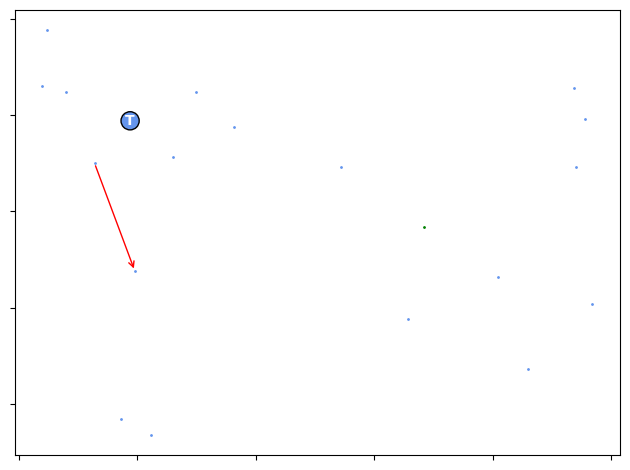

In [42]:
fig, ax = plt.subplots(1)  # Prepare 2 plots
ax.set_yticklabels([])
ax.set_xticklabels([])
for i, (x, y) in enumerate(problem.coords):
    ax.scatter(x, y, s=1, c="green" if i == 5 else "cornflowerblue")  # plot A

for i in range(len(ordered_state)):
    start_node = ordered_state[i]
end_node = ordered_state[(i + 1) % len(ordered_state)]
start_pos = problem.coords[start_node]
end_pos = problem.coords[end_node]
ax.annotate(
    "",
    xy=start_pos,
    xycoords="data",
    xytext=end_pos,
    textcoords="data",
    c="red",
    arrowprops=dict(arrowstyle="->", ec="red", connectionstyle="arc3"),
)
node_labels = {k: str(v) for k, v in enumerate(string.ascii_uppercase) if k < len(problem.source_graph.nodes)}

for i in node_labels.keys():
    x, y = problem.coords[i]
plt.text(
    x,
    y,
    node_labels[i],
    ha="center",
    va="center",
    c="white",
    fontweight="bold",
    bbox=dict(boxstyle=f"circle,pad=0.15", fc="green" if i == ordered_state[0] else "cornflowerblue"),
)

plt.tight_layout()
plt.show()

And, to verify that the route is correct (or at least, the shortest one found):

In [43]:
all_edge_lengths = {(x, y): d for x, y, d in problem.distances}
all_edge_lengths.update({(y, x): d for x, y, d in problem.distances})

route_length = sum([all_edge_lengths[k] for k in edge_labels.keys()])
print(f"route_length: ({round(route_length, 6)}) equal to best_fitness: ({round(best_fitness, 6)})")

route_length: (941.582778) equal to best_fitness: (941.582778)


### Example 4: Using the NNGSRunner with the RHC algorithm

In [44]:
# Load and Split data into training and test sets
data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    data.data, data.target, test_size=0.3, random_state=123456
)

# Normalize feature data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# One hot encode target values
one_hot = OneHotEncoder()
y_train_hot = np.asarray(one_hot.fit_transform(y_train.reshape(-1, 1)).todense())
y_test_hot = np.asarray(one_hot.transform(y_test.reshape(-1, 1)).todense())

grid_search_parameters = {
    'max_iters': [1000],  # nn params
    'learning_rate': [1e-2, 1e-1],  # nn params
    'activation': [mlrose.relu, mlrose.tanh],  # nn params
    'hidden_layer_sizes': [[8, 4, 2], [10, 10], [50, 20, 10]],  ## nn params
    'restarts': [1, 5],  # rhc params
}

nnr = NNGSRunner(x_train=X_train_scaled, y_train=y_train_hot, x_test=X_test_scaled, y_test=y_test_hot, experiment_name='nn_test_rhc',
                 algorithm=mlrose.algorithms.rhc.random_hill_climb, grid_search_parameters=grid_search_parameters,
                 iteration_list=[1, 10, 50, 100, 250, 500, 1000], clip_max=5, n_jobs=-1, seed=123456)

run_stats_df, curves_df, cv_results_df, grid_search_cv = nnr.run()

Fitting 5 folds for each of 24 candidates, totalling 120 fits


The runner returns the `run_stats` and `curves` corresponding to *best* hyperparameter combination,
as well as the cross validation results and the underlying `GridSearchCV` object used in the run.

In [45]:
y_test_pred = grid_search_cv.predict(X_test_scaled)
y_test_accuracy = accuracy_score(np.asarray(y_test_hot), y_test_pred)
y_test_accuracy

0.7777777777777778

In [46]:
y_train_pred = grid_search_cv.predict(X_train_scaled)
y_train_accuracy = accuracy_score(y_train_hot, y_train_pred)
y_train_accuracy

0.7523809523809524

Run stats dataframe

In [47]:
run_stats_df[["current_restart", "Iteration", "Fitness", "FEvals", "Time", "learning_rate"]][:14]

current_restart  Iteration   Fitness  FEvals      Time  learning_rate
0                 0          0  1.077331       1  0.002015           0.01
1                 0          1  1.077331       2  0.003929           0.01
2                 0         10  1.071151      18  0.010381           0.01
3                 0         50  1.037855      76  0.029125           0.01
4                 0        100  1.002194     147  0.051457           0.01
5                 0        250  1.002194     147  0.051457           0.01
6                 0        500  1.002194     147  0.051457           0.01
7                 0       1000  1.002194     147  0.051457           0.01
8                 1          0  1.077331     147  0.052764           0.01
9                 1          1  1.077328     149  0.054245           0.01
10                1         10  1.073159     162  0.059434           0.01
11                1         50  1.054449     222  0.078844           0.01
12                1        100  1.017755     299  0.103964           0.01
13                1        250  1.017755     299  0.103964           0.01

curves dataframe

In [48]:
curves_df[["current_restart", "Iteration", "Fitness", "FEvals", "Time", "learning_rate"]][:20]

current_restart  Iteration   Fitness  FEvals      Time  learning_rate
0                 0          1  1.076586     2.0  0.003929           0.01
1                 0          2  1.076586     4.0  0.005489           0.01
2                 0          3  1.073931     6.0  0.006160           0.01
3                 0          4  1.073821     8.0  0.006783           0.01
4                 0          5  1.072526    10.0  0.007384           0.01
5                 0          6  1.072526    11.0  0.007684           0.01
6                 0          7  1.072326    13.0  0.008274           0.01
7                 0          8  1.072173    15.0  0.009378           0.01
8                 0          9  1.071151    17.0  0.010049           0.01
9                 0         10  1.071151    18.0  0.010381           0.01
10                0         11  1.071109    20.0  0.012184           0.01
11                0         12  1.071109    21.0  0.012500           0.01
12                0         13  1.070694    23.0  0.013095           0.01
13                0         14  1.070694    24.0  0.013401           0.01
14                0         15  1.069687    26.0  0.014003           0.01
15                0         16  1.067578    28.0  0.014618           0.01
16                0         17  1.067416    30.0  0.015217           0.01
17                0         18  1.067416    31.0  0.015527           0.01
18                0         19  1.067416    32.0  0.015858           0.01
19                0         20  1.067416    33.0  0.016204           0.01

cv results dataframe

In [49]:
cv_results_df[
    [
        "mean_test_score",
        "rank_test_score",
        "mean_train_score",
        "param_activation",
        "param_hidden_layer_sizes",
        "param_learning_rate",
        "param_max_iter",
        "param_restarts",
    ]
]

mean_test_score  rank_test_score  mean_train_score param_activation  \
0          0.320000               19          0.328516             relu   
1          0.333333               17          0.333333             relu   
2          0.320000               19          0.328516             relu   
3          0.333333               17          0.333333             relu   
4          0.362143               13          0.380620             relu   
5          0.403360                9          0.427470             relu   
6          0.362143               13          0.380620             relu   
7          0.403360                9          0.427470             relu   
8          0.190556               23          0.192572             relu   
9          0.402381               11          0.393729             relu   
10         0.190556               23          0.192572             relu   
11         0.402381               11          0.393729             relu   
12         0.712275                1          0.702290             tanh   
13         0.588836                3          0.550439             tanh   
14         0.712275                1          0.702290             tanh   
15         0.588836                3          0.550439             tanh   
16         0.453413                7          0.435486             tanh   
17         0.530794                5          0.555838             tanh   
18         0.453413                7          0.435486             tanh   
19         0.530794                5          0.555838             tanh   
20         0.303333               21          0.307246             tanh   
21         0.340000               15          0.319487             tanh   
22         0.303333               21          0.307246             tanh   
23         0.340000               15          0.319487             tanh   

   param_hidden_layer_sizes  param_learning_rate  param_max_iter  \
0                 [8, 4, 2]                 0.01            1000   
1                 [8, 4, 2]                 0.01            1000   
2                 [8, 4, 2]                 0.10            1000   
3                 [8, 4, 2]                 0.10            1000   
4                  [10, 10]                 0.01            1000   
5                  [10, 10]                 0.01            1000   
6                  [10, 10]                 0.10            1000   
7                  [10, 10]                 0.10            1000   
8              [50, 20, 10]                 0.01            1000   
9              [50, 20, 10]                 0.01            1000   
10             [50, 20, 10]                 0.10            1000   
11             [50, 20, 10]                 0.10            1000   
12                [8, 4, 2]                 0.01            1000   
13                [8, 4, 2]                 0.01            1000   
14                [8, 4, 2]                 0.10            1000   
15                [8, 4, 2]                 0.10            1000   
16                 [10, 10]                 0.01            1000   
17                 [10, 10]                 0.01            1000   
18                 [10, 10]                 0.10            1000   
19                 [10, 10]                 0.10            1000   
20             [50, 20, 10]                 0.01            1000   
21             [50, 20, 10]                 0.01            1000   
22             [50, 20, 10]                 0.10            1000   
23             [50, 20, 10]                 0.10            1000   

    param_restarts  
0                1  
1                5  
2                1  
3                5  
4                1  
5                5  
6                1  
7                5  
8                1  
9                5  
10               1  
11               5  
12               1  
13               5  
14               1  
15               5  
16               1  
17               5  
18               1  
19     